# Learning TorchData Through Examples

What follows is really more of a tutorial aggregator. I've tried to pull together the best pieces I've found from several TorchData tutorials and code snippets, and reorganize them all into one place. In many cases I've copied directly from the source text, in some cases with minor edits, with the notion that the descriptions provided by the authors' of these libraries are already incredibly succinct.

<a id="0"></a> <br>
## Table of Contents
1. [Introduction to TorchData](#1)
    1. [Overview](#2)
    1. [Why composable data loading](#3)
    1. [What are DataPipes?](#4)
1. [Installation](#5)
    1. [Prerequisites](#6)
    1. [Installing](#7)
    1. [Verifying installation](#8)
1. [DataPipes Tutorial](#9)
    1. [Using DataPipes](#10)
    1. [Class constructor vs. Functional form](#11)
    1. [IterDataPipes vs. MapDataPipes](#12)
1. [Tabular Data Examples](#13)
    1. [Using a DataPipe with DataLoader](#14)
    1. [Multiprocessing](#15)
    1. [DataLoader vs. DataLoader2](#16)
    1. [Splitting data](#17)
    1. [Computing number of samples](#18)
    1. [TorchArrow](#19)
1. [Vision Data Examples](#20)
    1. [Torchvision](#21)
    1. [Image Folder](#22)
        1. [Visualizing DataPipes](#23)
    1. [WebDataset](#24)
        1. [Creating WebDataset data](#25)
        1. [Using the WebDataset DatPipe](#26)
        1. [Speeding up transforms with Kornia](#27)
    1. [Object detection example](#28)
1. [Language Data Examples](#29)
    1. [TorchText](#30)
    1. [HuggingFace](#31)
1. [Custom DataPipes](#32)
1. [Distributed dataloading](#33)
    1. [Running on SageMaker](#34)
1. [S3FileLoader](#35)
1. [AIStore on S3](#36)
1. [References](#37)

----

## Introduction to TorchData <a class="anchor" id="1"></a>

### Overview [[1]](https://github.com/pytorch/data/blob/main/README.md#torchdata) <a class="anchor" id="2"></a>

[torchdata](https://github.com/pytorch/data) is library of common modular data loading primitives for easily constructing flexible and performant data pipelines. It is currently in a Beta release.

This library introduces composable Iterable-style and Map-style building blocks called DataPipes that work well out of the box with the PyTorch's DataLoader. These built-in DataPipes have the necessary functionalities to reproduce many different datasets in TorchVision and TorchText, namely loading files (from local or cloud), parsing, caching, transforming, filtering, and many more utilities.

### Why composable data loading? [[2]](https://github.com/pytorch/data/blob/main/README.md#why-composable-data-loading) <a class="anchor" id="3"></a>

Over many years of feedback and organic community usage of the PyTorch `DataLoader` and `Dataset`, we've found that:

1. The original `DataLoader` bundled too many features together, making them difficult to extend, manipulate, or replace. This has created a proliferation of use-case specific `DataLoader` variants in the community rather than an ecosystem of interoperable elements.

2. Many libraries, including each of the PyTorch domain libraries, have rewritten the same data loading utilities over and over again. We can save OSS maintainers time and effort rewriting, debugging, and maintaining these table-stakes elements.

Fun fact: [fastai](https://github.com/fastai/fastai) featured composable PyTorch dataloading via their DataBlock API several years ago. Its ease of use and modularity was one of the driving factors responsible for the popularity of the library.

#### I/O bottlenecks

GPUs continue to get faster. With new GPUs such as the the NVIDIA A100 or new H100, I/O and memory become more likely candidates for bottlenecks. We want to ensure that data loading doesn't become a bottleneck and the GPU never has to wait for a batch of new data, so we'd like to pay close attention to developing fast, reusable components for this process.

### What are DataPipes? [[3]](https://github.com/pytorch/data/blob/main/README.md#what-are-datapipes) <a class="anchor" id="4"></a>

Early on, we observed widespread confusion between the PyTorch `Dataset` which represented reusable loading tooling (e.g. [TorchVision's `ImageFolder`](https://github.com/pytorch/vision/blob/main/torchvision/datasets/folder.py#L272), and those that represented pre-built iterators/accessors over actual data corpora (e.g. TorchVision's [ImageNet](https://github.com/pytorch/vision/blob/main/torchvision/datasets/imagenet.py#L21)). This led to an unfortunate pattern of siloed inheritance of data tooling rather than composition.

`DataPipe` is simply a renaming and repurposing of the PyTorch `Dataset` for composed usage. A `DataPipe` takes in some access function over Python data structures, `__iter__` for `IterDataPipes` and `__getitem__` for `MapDataPipes`, and returns a new access function with a slight transformation applied. For example, take a look at this `JsonParser`, which accepts an IterDataPipe over file names and raw streams, and produces a new iterator over the filenames and deserialized data:

```python
    import json
    from torchdata.datapipes.iter import IterDataPipe

    class JsonParserIterDataPipe(IterDataPipe):
        def __init__(self, source_datapipe, **kwargs) -> None:
            self.source_datapipe = source_datapipe
            self.kwargs = kwargs

        def __iter__(self):
            for file_name, stream in self.source_datapipe:
                data = stream.read()
                yield file_name, json.loads(data, **self.kwargs)

        def __len__(self):
            return len(self.source_datapipe)
```

You can see in this example how DataPipes can be easily chained together to compose graphs of transformations that reproduce sophisticated data pipelines, with streamed operation as a first-class citizen.

Under this naming convention, `Dataset` simply refers to a graph of `DataPipes`, and a dataset module like `ImageNet` can be rebuilt as a factory function returning the requisite composed `DataPipes`. Note that the vast majority of initial support is focused on `IterDataPipes`, while more `MapDataPipes` support will come later.

----

## Installation <a class="anchor" id="5"></a>

### Prerequisites <a class="anchor" id="6"></a>

This code was tested using CUDA 11.6. To install a particular version of CUDA, your NVIDIA driver's compatibility version must be greater or equal to the CUDA version (top-right in `nvidia-smi`).

Most of the setup can be accomplished in a few simple commands described below. A few examples require a [Kaggle](https://www.kaggle.com) account and [API key](https://www.kaggle.com/docs/api#authentication) to run a dataset download command.

### Installing <a class="anchor" id="7"></a>

The libraries used in this tutorial can be installed by creating a Conda environment using the provided `environment.yml`:


```bash
    # Install mamba for faster conda installs
    conda install mamba -n base -c conda-forge

    # Create the environment with mamba
    mamba env create --name torchdata --file=environment.yml
```

If the above installation was successful, you should be able to select `torchdata` as your Jupyter kernel.

### Verifying installation <a class="anchor" id="8"></a>

In [20]:
import sys
from pkg_resources import parse_version as pv

import torch
import torcharrow
import torchtext
import torchvision
import torchdata

assert sys.version_info == (3, 8, 0, 'final', 0), "Use Python 3.8.0"
assert torch.cuda.is_available(), "This notebook requires GPU support."
assert torch.version.cuda == "11.6", "This notebook was tested with CUDA 11.6"
assert pv(torch.__version__) >= pv("2.0.0.dev20230201")
assert pv(torchvision.__version__) >= pv("0.15.0.dev20230201")
assert pv(torchtext.__version__) >= pv("0.15.0.dev20230201")
assert pv(torchdata.__version__) >= pv("0.6.0.dev20230201")
assert pv(torcharrow.__version__) >= pv("0.2.0a0.dev20230201")

Run a quick sanity check in python:

In [ ]:
import dill

from torchdata.datapipes.iter import HttpReader

URL = "https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv"

ag_news_train = HttpReader([URL]).parse_csv().map(lambda t: (int(t[0]), " ".join(t[1:])))
agn_batches = ag_news_train.batch(2).map(lambda batch: {'labels': [sample[0] for sample in batch],\
            'text': [sample[1].split() for sample in batch]})

batch = next(iter(agn_batches))
assert batch['text'][0][0:8] == ['Wall', 'St.', 'Bears', 'Claw', 'Back', 'Into', 'the', 'Black']

**Note:** lambda is unpicklable without the `dill` library installed, therefore can't do multiprocessing when using lambda functions and would need to define functions passed to `.map()` calls explicitly, e.g.:

```python
    def map_fn1(t):
        return (int(t[0]), " ".join(t[1:]))

    def map_fn2(batch):
        return {'labels': [sample[0] for sample in batch],\
                'text': [sample[1].split() for sample in batch]}

    ag_news_train = HttpReader([URL]).parse_csv().map(map_fn1)
    agn_batches = ag_news_train.batch(2).map(map_fn2)
```

Also note that you may wrap a function with `functools.partial` or use the function `operator.itemgetter` to simplify `.map(function)` calls.

----

## DataPipes Tutorial [[4]](https://pytorch.org/data/main/tutorial.html) <a class="anchor" id="9"></a>

The gist is that functionality which was traditionally part of DataLoader will now move to composable DataPipes (shuffling, batch size, etc.). `DataPipe` is currently compatible with the existing `DataLoader` and can be used as a drop-in replacement for `Dataset`, however, in the future, `DataLoader2` will function as a leaner dataloader specifically for use with DataPipes. [[5]](https://sebastianraschka.com/blog/2022/datapipes.html)


### Using DataPipes <a class="anchor" id="10"></a>

Suppose that we want to load data from CSV files with the following steps:

- List all CSV files in a directory
- Load CSV files
- Parse CSV file and yield rows
- Split our dataset into training and validation set

There are a few [built-in DataPipes](https://pytorch.org/data/main/torchdata.datapipes.iter.html) that can help us with the above operations.

- `FileLister` - [lists out files in a directory](https://pytorch.org/data/main/generated/torchdata.datapipes.iter.FileLister.html)
- `Filter` - [filters the elements in DataPipe based on a given function](https://pytorch.org/data/beta/generated/torchdata.datapipes.iter.Filter.html)
- `FileOpener` - [consumes file paths and returns opened file streams](https://pytorch.org/data/beta/generated/torchdata.datapipes.iter.FileOpener.html)
- `CSVParser` - [consumes file streams, parses the CSV contents, and returns one parsed line at a time](https://pytorch.org/data/beta/generated/torchdata.datapipes.iter.CSVParser.html)
- `RandomSplitter` - [randomly split samples from a source DataPipe into groups](https://pytorch.org/data/beta/generated/torchdata.datapipes.iter.RandomSplitter.html)

As an example, the source code for `CSVParser` looks something like this:

```python
    @functional_datapipe("parse_csv")
    class CSVParserIterDataPipe(IterDataPipe):
        def __init__(self, dp, **fmtparams) -> None:
            self.dp = dp
            self.fmtparams = fmtparams

        def __iter__(self) -> Iterator[Union[Str_Or_Bytes, Tuple[str, Str_Or_Bytes]]]:
            for path, file in self.source_datapipe:
                stream = self._helper.skip_lines(file)
                stream = self._helper.strip_newline(stream)
                stream = self._helper.decode(stream)
                yield from self._helper.return_path(stream, path=path)  # Returns 1 line at a time as List[str or bytes]
```

### Class constructors vs. Functional form <a class="anchor" id="11"></a>

DataPipes can be used via their class construction or functional form (a method call). The PyTorch team recommends using the funtional form, which is available to most but not all DataPipes. For example:

Using *class constructors*:

```python
    new_dp = dp.iter.FileOpener([csv_file])
    new_dp = dp.iter.CSVParser(new_dp, skip_lines=1)
    # returns tuples like ('train/0/16585.png', '0')
```

Using *functional form*:

```python
    new_dp = dp.iter.FileOpener([csv_file])
    new_dp = new_dp.parse_csv(skip_lines=1)
    # returns tuples like ('train/0/16585.png', '0')
```

A pipeline can be assembled with a mix of using class constructors and their functional forms, for example:

```python
    FOLDER = 'path/2/csv/folder'
    datapipe = dp.iter.FileLister([FOLDER]).filter(filter_fn=lambda filename: filename.endswith('.csv'))
    datapipe = dp.iter.FileOpener(datapipe, mode='rt')
    datapipe = datapipe.parse_csv(delimiter=',')
    N_ROWS = 10000  # total number of rows of data
    train, valid = datapipe.random_split(total_length=N_ROWS, weights={"train": 0.5, "valid": 0.5}, seed=0)

    for x in train:  # Iterating through the training dataset
        pass

    for y in valid:  # Iterating through the validation dataset
        pass
```

### IterDataPipes vs. MapDataPipes <a class="anchor" id="12"></a>

You can find the full list of built-in [IterDataPipes here](https://pytorch.org/data/main/torchdata.datapipes.iter.html) and [MapDataPipes here](https://pytorch.org/data/main/torchdata.datapipes.map.html).

#### Map-style DataPipes

A Map-style DataPipe is one that implements the `__getitem__()` and `__len__()` protocols, and represents a map from (possibly non-integral) indices/keys to data samples. This is a close equivalent of `Dataset` from the PyTorch core library.

For example, when accessed with `mapdatapipe[idx]`, could read the idx-th image and its corresponding label from a folder on the disk.

All datasets that represent a map from keys to data samples should subclass `torchdata.datapipes.map.MapDataPipe` and overwrite `__getitem__()` and (optionally) `__len__()`.

#### Iterable-style DataPipes

An iterable-style dataset is an instance of a subclass of IterableDataset that implements the `__iter__()` protocol, and represents an iterable over data samples. This type of datasets is particularly suitable for cases where random reads are expensive or even improbable, and where the batch size depends on the fetched data.

For example, such a dataset, when called `iter(iterdatapipe)`, could return a stream of data reading from a database, a remote server, or even logs generated in real time.

This is an updated version of `IterableDataset` in torch.

All DataPipes that represent an iterable of data samples should subclass `torchdata.datapipes.iter.IterDataPipe`.


#### Conversion

An `IterDataPipe` can be converted to a `MapDataPipe` using either `IterToMapConverter` or `.to_map_datapipe()`. 

Currently TorchData has placed more emphasis and effort on developing `IterDataPipe`s, so there are many more available compared to `MapDataPipe`s.

----

## Tabular Data Examples <a class="anchor" id="13"></a>

Below is an example of creating a DataPipe for tabular CS data using TorchData's functional form. 

Lets first use a helper function to generate some CSV files with random data and labels.

In [ ]:
import csv
import random

!mkdir -p data/csv

def generate_csv(file_label, num_rows: int = 5000, num_features: int = 20) -> None:
    fieldnames = ['label'] + [f'c{i}' for i in range(num_features)]
    writer = csv.DictWriter(open(f"data/csv/sample_data{file_label}.csv", "w", newline=''), fieldnames=fieldnames)
    writer.writeheader()
    for i in range(num_rows):
        row_data = {col: random.random() for col in fieldnames}
        row_data['label'] = random.randint(0, 9)
        writer.writerow(row_data)

# Generate 3 csv files with 10 rows and 3 features
num_files_to_generate = 3
for i in range(num_files_to_generate):
    generate_csv(file_label=i, num_rows=10, num_features=3)

# List the generated csv files
!ls data/csv

# Print the first 3 lines of the first csv file
!head -n3 data/csv/sample_data0.csv

Next, we will build our DataPipes to read and parse through the generated CSV files. Note that we prefer to have pass defined functions to DataPipes rather than lambda functions because the formers are serializable with *pickle* (if you don't have the `dill` package installed you will receive a warning when using a lambda function, which indicates that the function is unpickleable and therefore multiprocessing can't be used).

In [ ]:
import numpy as np
import torchdata.datapipes as dp


def filter_for_data(filename):
    return "sample_data" in filename and filename.endswith(".csv")

def row_processer(row):
    return {"label": np.array(row[0], np.int32), "data": np.array(row[1:], dtype=np.float64)}

def build_datapipes(root_dir="."):
    datapipe = dp.iter.FileLister(root_dir)
    datapipe = datapipe.filter(filter_fn=filter_for_data)
    datapipe = datapipe.open_files(mode='rt')
    datapipe = datapipe.parse_csv(delimiter=",", skip_lines=1)
    # Shuffle will happen as long as you do NOT set `shuffle=False` later in the DataLoader
    datapipe = datapipe.shuffle()
    # Make sure distributed sharding is mutually exclusive and collectively exhaustive
    datapipe = datapipe.sharding_filter()
    datapipe = datapipe.map(row_processer)
    return datapipe

### Using a DataPipe with DataLoader <a class="anchor" id="14"></a>

And now we can use a `DataPipe` with `DataLoader`. For the most part, you should be able to use it just by passing `dataset=datapipe` as an input argument into the DataLoader. For detailed documentation related to DataLoader, please visit [this page](https://pytorch.org/docs/stable/data.html#single-and-multi-process-data-loading).

Here we will set shuffling by the DataPipe, but batching and multiprocessing by the DataLoader.

Note that if you choose to use `Batcher` while setting `batch_size > 1` for DataLoader, your samples will be batched more than once. You should choose one or the other.


#### Multiprocessing important caveats [[6]](https://github.com/pytorch/data#frequently-asked-questions-faq) <a class="anchor" id="15"></a>

- Multi-process data loading is still handled by the `DataLoader`, see the [DataLoader documentation for more details](https://pytorch.org/docs/stable/data.html#single-and-multi-process-data-loading). As of PyTorch version >= 1.12.0 (TorchData version >= 0.4.0), data sharding is automatically done for `DataPipes` within the `DataLoader` as long as a `ShardingFilter` (`datapipe.sharding_filter`) DataPipe exists in your pipeline. Sharding filter is a necessary workaround to avoid data duplication when we use more than 1 worker.
- Place `ShardingFilter` (`datapipe.sharding_filter`) as early as possible in the pipeline, especially before expensive operations such as decoding, in order to avoid repeating these expensive operations across worker/distributed processes.
- For the data source that needs to be sharded, it is crucial to add Shuffler before ShardingFilter to ensure data are globally shuffled before splitted into shards. Otherwise, each worker process would always process the same shard of data for all epochs. And, it means each batch would only consist of data from the same shard, which leads to low accuracy during training. However, it doesn’t apply to the data source that has already been sharded for each multi-/distributed process, since ShardingFilter is no longer required to be presented in the pipeline.
- There may be cases where placing Shuffler earlier in the pipeline lead to worse performance, because some operations (e.g. decompression) are faster with sequential reading. In those cases, we recommend decompressing the files prior to shuffling (potentially prior to any data loading).

In [ ]:
from torch.utils.data import DataLoader

datapipe = build_datapipes(root_dir='./data/csv')
dl = DataLoader(dataset=datapipe, batch_size=5, num_workers=2)

In [ ]:
batch = next(iter(dl))
labels, features = batch['label'], batch['data']

print(f"Labels batch shape: {labels.size()}")
print(f"Feature batch shape: {features.size()}")
print(f"{labels = }\n{features = }")

n_sample = 0
for row in iter(dl):
    n_sample += 1
print(f"{n_sample = }")

### DataLoader vs [DataLoader2](https://pytorch.org/data/beta/dataloader2.html#id1) [[7]](https://pytorch.org/data/beta/dataloader2.html#module-torchdata.dataloader2) <a class="anchor" id="16"></a>

A light-weight `DataLoader2` has been introduced to decouple the overloaded data-manipulation functionalities from `torch.utils.data.DataLoader` to `DataPipe` operations. Certain features can only be achieved with DataLoader2 like snapshotting and switching backend services to perform high-performant operations.

#### Using a DataPipe with DataLoader2

TorchData's light-weight `torchdata.dataloader2.DataLoader2` no longer includes batching or shuffling options to avoid confusion. We'll do shuffling and batching by the DataPipe, and multiprocessing via `DataLoader2`'s `reading_service`.

In [ ]:
from torchdata.dataloader2 import (DataLoader2,
                                   PrototypeMultiProcessingReadingService)

# We'll add batching and collating (with default collate_fn) to the datapipe
datapipe = build_datapipes(root_dir='./data/csv').batch(batch_size=5).collate()

# PrototypeMultiProcessingReadingService is subject to change, check the notes on this for more details:
# https://github.com/pytorch/data/blob/main/torchdata/dataloader2/reading_service.py#L124
reading_service = PrototypeMultiProcessingReadingService(num_workers=2)

dl = DataLoader2(datapipe=datapipe, reading_service=reading_service)

In [ ]:
batch = next(iter(dl))
labels, features = batch['label'], batch['data']

print(f"Labels batch shape: {labels.size()}")
print(f"Feature batch shape: {features.size()}")
print(f"{labels = }\n{features = }")

n_sample = 0
for row in iter(dl):
    n_sample += 1
print(f"{n_sample = }")

In [ ]:
# Notice iter DataPipe has no length by default
try:
    len(datapipe)
except Exception as e:
    print(e)

# But it can be set
datapipe = datapipe.set_length(len(list(datapipe)))
len(datapipe)

### Splitting data <a class="anchor" id="17"></a>

In [ ]:
import numpy as np
import torchdata.datapipes as dp


def filter_for_data(filename):
    return "sample_data" in filename and filename.endswith(".csv")

def row_processer(row):
    return {"label": np.array(row[0], np.int32), "data": np.array(row[1:], dtype=np.float64)}

def build_datapipes(N_ROWS, batch_size=5, root_dir="."):
    datapipe = dp.iter.FileLister(root_dir)
    datapipe = datapipe.filter(filter_fn=filter_for_data)
    datapipe = datapipe.open_files(mode='rt')
    datapipe = datapipe.parse_csv(delimiter=",", skip_lines=1)
    # Shuffle will happen as long as you do NOT set `shuffle=False` later in the DataLoader
    datapipe = datapipe.shuffle()
    datapipe = datapipe.map(row_processer)
    datapipe = datapipe.sharding_filter()
    datapipe = datapipe.batch(batch_size)
    datapipe = datapipe.collate()
    train, valid = datapipe.random_split(total_length=N_ROWS, weights={"train": 0.5, "valid": 0.5}, seed=0)
    return train, valid

N_ROWS = 30
train, valid = build_datapipes(N_ROWS, root_dir='./data/csv')

for batch in train:
    pass
for batch in valid:
    pass

# Since random_split required total_length, now we have __len__ for datapipes
len(train), len(valid)

### Computing the number of samples [[8]](https://github.com/pytorch/vision/tree/main/torchvision/prototype/datasets/_builtin#how-do-i-compute-the-number-of-samples) <a class="anchor" id="18"></a>

Unless the authors of the dataset published the exact numbers (even in this case we should check), there is no other way than to iterate over the dataset and count the number of samples:

```python
    import itertools
    from torchvision.prototype import datasets


    def combinations_grid(**kwargs):
        return [dict(zip(kwargs.keys(), values)) for values in itertools.product(*kwargs.values())]


    # If you have implemented the mock data function for the dataset tests, you can simply copy-paste from there
    configs = combinations_grid(split=("train", "test"), foo=("bar", "baz"))

    for config in configs:
        dataset = datasets.load("my-dataset", **config)

        num_samples = 0
        for _ in dataset:
            num_samples += 1

        print(", ".join(f"{key}={value}" for key, value in config.items()), num_samples)
```

To speed this up, it is useful to temporarily comment out all unnecessary I/O, such as loading of images or annotation files.

### TorchArrow [[9]](https://github.com/pytorch/torcharrow#torcharrow-a-data-processing-library-for-pytorch) <a class="anchor" id="19"></a>

TorchArrow is a `torch.Tensor`-like Python DataFrame library for data preprocessing in PyTorch models, with two high-level features:

- DataFrame library (like Pandas) with strong GPU or other hardware acceleration (under development) and PyTorch ecosystem integration.
- Columnar memory layout based on Apache Arrow with strong variable-width and nested data support (such as string, list, map) and Arrow ecosystem integration.

TorchArrow is currently integrated with TorchData in two ways:
- `DataFrameMaker`: Takes rows of data, batches a number of them together and creates TorchArrow DataFrames (functional name: `dataframe`).
- `ParquetDataFrameLoader`: Takes in paths to Parquet files and return a TorchArrow DataFrame for each row group within a Parquet file (functional name: `load_parquet_as_df`).

In [ ]:
import torcharrow as ta
import torcharrow.dtypes as dt
from torchdata.datapipes.iter import (DataFrameMaker, FileLister,
                                      IterableWrapper, ParquetDataFrameLoader)

device = 'cpu'

#### DataFrameMaker

In [ ]:
# Create example DataPipe
source_data = [(i,) for i in range(10)]
source_dp = IterableWrapper(source_data)

In [ ]:
# Take rows of data and convert to single TorchArrow DataFrame
DTYPE = dt.Struct([dt.Field("Values", dt.int32)])
df_dp = source_dp.dataframe(dtype=DTYPE)
df = list(df_dp)[0]

print(type(df))
print(df.length)
df.head(2)

In [ ]:
# Take DataPipe and convert into multiple TorchArrow DataFrames, based on size argument 
df_dp = DataFrameMaker(source_dp, dataframe_size=5, dtype=DTYPE, device=device, dtype_generator=None, columns=None)
dfs = list(df_dp)

print(len(dfs))
for df in dfs:
    print(df.length)
    print(df.head(2))

#### ParquetDataFrameLoader

In [ ]:
# Create TorchArrow DataFrames
DTYPE = dt.Struct([dt.Field("Values", dt.int32)])
df1 = ta.dataframe([(i,) for i in range(10)], dtype=DTYPE)
df2 = ta.dataframe([(i,) for i in range(100)], dtype=DTYPE)

In [ ]:
# Write them as parquet files
import os
import pyarrow
import pyarrow.parquet as parquet

!mkdir -p data/parquet
dir_path = "data/parquet"

for i, df in enumerate([df1, df2]):

    # Write df as parquet
    table = df.to_arrow()
    parquet.write_table(table, os.path.join(dir_path, f"df{i}.parquet"))

    # write multiple dfs as parquet
    dfs = [df1, df2]
    tables = [df.to_arrow() for df in dfs]
    merged_table = pyarrow.concat_tables(tables)
    parquet.write_table(merged_table, os.path.join(dir_path, "merged.parquet"))

!ls data/parquet

In [ ]:
# Read from Parquet files and output TorchArrow DataFrames
DTYPE = dt.Struct([dt.Field("Values", dt.int32)])
source_dp = FileLister(dir_path, masks="df*.parquet")
parquet_df_dp = ParquetDataFrameLoader(source_dp, dtype=DTYPE)

for df in parquet_df_dp:
    print(type(df), df.length)

In [ ]:
# Read from a Parquet file that was a merged DataFrame
merged_source_dp = FileLister(dir_path, masks="merged.parquet")
merged_parquet_df_dp = ParquetDataFrameLoader(merged_source_dp, dtype=DTYPE, device=device, use_threads=True, columns=None)

for df in merged_parquet_df_dp:
    print(type(df), df.length)

## Vision Data Examples <a class="anchor" id="20"></a>

### Torchvision <a class="anchor" id="21"></a>

In [ ]:
from torchvision.prototype import datasets
datasets.list_datasets()

In [ ]:
datasets.info("cifar10")

Most built-in datasets can be downloaded automatically when calling `dataset.load()`, some cannot due to license restrictions (for example ImageNet). In this case you will receive a `RuntimeError` that will provide instructions for downloading.

In [ ]:
from torchdata.datapipes.iter import IterDataPipe
from torchvision.prototype import datasets

dataset = datasets.load("cifar10")
for sample in dataset:
    print(sample)  # this is the content of an item in datapipe returned by _datapipe()
    break

# Notice that dataset is a subclass of IterDataPipe
assert issubclass(type(dataset), IterDataPipe)

In [ ]:
# By default (if `root` is not provided), downloads will be saved in ~/.cache/torch/datasets/vision/
!ls ~/.cache/torch/datasets/vision/

### Image Folder [[10]](https://github.com/pytorch/data/blob/main/examples/vision/imagefolder.py) <a class="anchor" id="22"></a>

Torchvision has the familiar and convenient `torchvision.datasets.ImageFolder` class, which is a generic dataloader that inherits from `DatasetFolder`. We can recreate the same functionality, but instead using DataPipes. The below DataPipes implementation of ImageFolder constructs and executes a graph of DataPipes (aka DataPipeline):

```text
FileLister -> ObtainCategories
                      ⬇
FileLister -> AttributeCategories -> LoadAndDecodeImages (using `map`) -> ApplyTorchVisionTransforms (using `map`)
```

In [ ]:
# Download fake data for this example from GitHub
!mkdir -p data/vision
!svn checkout https://github.com/pytorch/data/trunk/examples/vision/fakedata/imagefolder data/vision/imagefolder
!rm -rf data/vision/imagefolder/.svn

# Check out the downloaded directory
!tree data/vision/imagefolder

In [ ]:
import http.server
import os
import re
import threading

import torchvision.datasets as datasets
import torchvision.datasets.folder
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader
from torchdata.datapipes.iter import FileLister, HttpReader, IterDataPipe


IMAGES_ROOT = "data/vision/imagefolder"

USE_FORK_DATAPIPE = False
NUM_WORKERS = 8
BATCH_SIZE = 32

data_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [ ]:
def get_category_name(path):
    rel_path = os.path.relpath(path, start=IMAGES_ROOT)
    elements = rel_path.split(os.sep)
    return elements[0]


class ObtainCategories(IterDataPipe):
    """ Creates a DataPipe that yields a dictionary of categories to IDs. """
    def __init__(self, source_dp, parse_category_fn=get_category_name) -> None:
        self.source_dp = source_dp
        self.parse_category_fn = parse_category_fn

    def __iter__(self):
        categories = set()
        for path in self.source_dp:
            categories.add(self.parse_category_fn(path))
        cat_to_id = {name: i for i, name in enumerate(sorted(categories))}
        yield cat_to_id


class AttributeCategories(IterDataPipe):
    """ Creates a DataPipe that yields a tuple of (data, category) """
    def __init__(self, listfiles_dp, categories_dp, parse_category_fn=get_category_name) -> None:
        self.listfiles_dp = listfiles_dp
        self.categories_dp = categories_dp
        self.parse_category_fn = parse_category_fn

    def __iter__(self):
        for categories in self.categories_dp:
            cat_to_dp = categories
        for data in self.listfiles_dp:
            if isinstance(data, tuple):
                category = cat_to_dp[self.parse_category_fn(data[0])]
                yield data + (category,)
            else:
                category = cat_to_dp[self.parse_category_fn(data)]
                yield (data, category)


def MyImageFolder(root=IMAGES_ROOT, transform=None):
    if not USE_FORK_DATAPIPE:
        # Yes, we had to scan files twice. Alternativelly it is possible to use
        # `fork` DataPipe, but it will require buffer equal to the size of all
        # full file names
        # TODO(125): Make sure that `fork` complains when buffer becomes too large
        list_files_0 = FileLister(root=root, recursive=True)
        list_files_1 = FileLister(root=root, recursive=True).sharding_filter()
    else:
        list_files_0, list_files_1 = FileLister(root=root, recursive=True).fork(2)
        list_files_1 = list_files_1.sharding_filter()

    categories = ObtainCategories(list_files_0)
    with_categories = AttributeCategories(list_files_1, categories)
    using_default_loader = with_categories.map(lambda x: (torchvision.datasets.folder.default_loader(x[0]), x[1]))
    transformed = using_default_loader.map(lambda x: (transform(x[0]), x[1]))
    return transformed

In [ ]:
dataset = MyImageFolder(root=IMAGES_ROOT, transform=data_transform)

dl = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

items = list(dl)
assert len(items) == 6

# Check first image size and class ID
print(items[0][0].shape, items[0][1])

#### Visualizing DataPipes <a class="anchor" id="23"></a>

We can also use a built-in graphviz utility to visualize our DataPipes

In [ ]:
from torchdata.datapipes.utils import to_graph

G = to_graph(dataset)
G

### WebDataset <a class="anchor" id="24"></a>

The [WebDataset Format](https://github.com/webdataset/webdataset#the-webdataset-format) is a relatively new format based on sharded tar files, and specifically designed for training with large datasets. WebDataset pipelines make it possibly to achieve higher I/O rates, among other benefits.

TorchData supports WebDataset through their WebDataset DataPipe: [torchdata.datapipes.iter.WebDataset](https://pytorch.org/data/beta/generated/torchdata.datapipes.iter.WebDataset.html#torchdata.datapipes.iter.WebDataset). WebDataset is also supported by NVIDIA DALI.

Note that SageMaker's [Fast File Mode](https://docs.aws.amazon.com/sagemaker/latest/dg/model-access-training-data.html) is also [more performant when using larger files](https://aws.amazon.com/blogs/machine-learning/choose-the-best-data-source-for-your-amazon-sagemaker-training-job/) like WebDataset Format's sharded tar files.

To start, we'll first download the [Dog Breed Identification dataset](https://www.kaggle.com/competitions/dog-breed-identification/data) from Kaggle and convert it to the WebDataset Format. Note that in order to complete this step you'll need the Kaggle CLI installed with an API token copied to `~/.kaggle/kaggle.json`. You'll also need to [accept the competition's terms](https://www.kaggle.com/competitions/dog-breed-identification/rules).

In [ ]:
# Download the dataset
!kaggle competitions download -c dog-breed-identification -p data/vision/dog-breed-identification
!cd data/vision/dog-breed-identification && unzip -q dog-breed-identification.zip

#### Convert Images and CSV labels to WebDataset Format <a class="anchor" id="25"></a>

In [ ]:
import os
import pickle
import random
import time

import pandas as pd
import webdataset as wds
from tqdm.auto import tqdm


def write_dogs_wd(root_dir='data/vision/dog-breed-identification', 
                  shard_dir='data/vision/webdataset',
                  maxsize=1e9, maxcount=100000, shuffle=False):

    assert maxsize > 10000000
    assert maxcount < 1000000

    if not os.path.exists(shard_dir):
        os.makedirs(shard_dir)

    root_dir = root_dir
    image_dir = os.path.join(root_dir, 'train/')
    img_list = pd.read_csv(os.path.join(root_dir, 'labels.csv'))
    idx2label=list(img_list['breed'].unique())
    label2idx = {b: i for i, b in enumerate(idx2label)}
    nimages = img_list.shape[0]
    print(f'nimages: {nimages}')
    indexes = list(range(nimages))
    if shuffle:
        random.shuffle(indexes)

    # This is the output pattern under which we write shards
    pattern = os.path.join(shard_dir, f'train-%06d.tar')
    with wds.ShardWriter(pattern, maxsize=int(maxsize), maxcount=int(maxcount), compress=False) as sink:

        for i in tqdm(indexes):
            key = f'{i:07d}'
            img_row = img_list.iloc[i]
            label = label2idx[img_row['breed']]
            #label = label.to_bytes(1, 'big')
            with open(os.path.join(image_dir, f"{img_row['id']}.jpg"), 'rb') as stream:
                image = stream.read()

            # Construct a sample
            sample = {'__key__': key, 'jpg': image, 'cls': label}

            # Write the sample to the sharded tar archives
            sink.write(sample)

    # Pickle class map
    with open(os.path.join(shard_dir, 'idx2label'), 'wb') as fp:
        pickle.dump(idx2label, fp)

    return idx2label

# Create dataset
shard_dir = "data/vision/webdataset"
idx2label = write_dogs_wd(maxcount=256, shuffle=False, shard_dir=shard_dir)

#### DataLoading with the original format

As a point of comparison, first we can check out what DataPipe construction with the non-convertered images and csv labels would look like. 

We'll run this next example as a script instead of directly in the notebook, since some multiprocessing functionality does not play well in an interactive environment.

In [ ]:
%%writefile jpeg_images_csv_labels.py

from pathlib import Path
import torch
import torchdata.datapipes as dp
import torchvision.transforms as transforms
#from torch.utils.data.datapipes.utils.decoder import imagehandler
from PIL import Image, features
import io
import os
from tqdm.auto import tqdm
import pandas as pd
from torchdata.dataloader2 import (DataLoader2,
                                   PrototypeMultiProcessingReadingService)
import PIL
# Check that PIL-SIMD is installed with libjpeg-turbo
assert "post" in PIL.__version__
assert features.check_feature('libjpeg_turbo')


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define simple transforms
data_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation((-45,45)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Define how to decode webdataset keys
def decode(item, transform=data_transform):
    key, value = item
    if key.endswith("jpg"):
        image = Image.open(io.BytesIO(value.read()))
        return key, transform(image)

ROOT = Path('data/vision/dog-breed-identification')

# Here we load all the labels ahead of time
labels = pd.read_csv(ROOT/'labels.csv')
idx2label=list(labels['breed'].unique())
label2idx = {b: i for i, b in enumerate(idx2label)}
labels_dict = pd.Series(labels.breed.values,index=labels.id).to_dict()

def collate_sample(data):
    paths, images = zip(*data)
    images = torch.stack(images).to(device)
    labels = [labels_dict[os.path.basename(path).split('.')[0]] for path in paths]
    classes = torch.Tensor([label2idx[label] for label in labels]).to(device)
    return classes, images


if __name__ == '__main__':

    BATCH_SIZE = 256
    NUM_WORKERS = 8

    datapipe = dp.iter.FileLister([ROOT/'train',], masks=['*.jpg'])
    datapipe = (datapipe
                .shuffle()
                .sharding_filter()
                .open_files(mode="b")
                .map(decode)
                .batch(BATCH_SIZE)
                .collate(collate_sample)
    )

    reading_service = PrototypeMultiProcessingReadingService(
        num_workers=NUM_WORKERS,
        # To use CUDA with multiprocessing, you must use the 'spawn' start method
        multiprocessing_context='spawn',
    )

    dl = DataLoader2(datapipe, reading_service=reading_service)

    for batch in tqdm(dl, mininterval=0.5):
        pass

    print(batch[1][1].shape, batch[1][1].device)

In [ ]:
!python jpeg_images_csv_labels.py

#### Using the WebDataset DataPipe <a class="anchor" id="26"></a>

Now here's an example of reading WebDataset Format:

In [ ]:
%%writefile webdataset_with_multiprocessing.py
import io
import os
#import pickle
from functools import partial

import torch
import torchvision.transforms as transforms
from PIL import Image, features
from tqdm.auto import tqdm
#from webdataset.autodecode import imagehandler
from torchdata.dataloader2 import (DataLoader2,
                                   PrototypeMultiProcessingReadingService)
from torchdata.datapipes.iter import FileLister, FileOpener
import PIL
# Check that PIL-SIMD is installed with libjpeg-turbo
assert "post" in PIL.__version__
assert features.check_feature('libjpeg_turbo')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define image decoders
#torch_handler = imagehandler('torch')

# Define simple transforms (since resizing is required to collate)
data_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation((-45,45)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Define how to decode webdataset keys
def decode(item, transform=data_transform):
    key, value = item
    if key.endswith(".cls"):
        class_id = int(value.read().decode("utf-8"))
        return key, class_id
    elif key.endswith(".jpg"):
        #image = image_decoder(".jpg", value.read())
        image = Image.open(io.BytesIO(value.read()))
        return key, transform(image)

# Define simple collate function
def collate_fn(batch, device=device):
    classes = torch.Tensor([sample['.cls'] for sample in batch]).to(device)
    images = torch.stack([sample['.jpg'] for sample in batch]).to(device)
    return classes, images


if __name__ == '__main__':

    BATCH_SIZE = 256
    NUM_WORKERS = 8

    # Create pipeline
    shard_dir = "data/vision/webdataset"
    datapipe = FileLister(shard_dir, "train*.tar")
    dataset = (datapipe
               .shuffle()
               .sharding_filter()
               .open_files(mode='b')
               .load_from_tar()
               .map(decode)
               .webdataset()
               .batch(BATCH_SIZE)
               # stack lists of tensors and place on device
               .collate(partial(collate_fn, device=device))
    )

    reading_service = PrototypeMultiProcessingReadingService(
        num_workers=NUM_WORKERS,
        # To use CUDA with multiprocessing, you must use the 'spawn' start method
        multiprocessing_context='spawn',
    )
    dl = DataLoader2(dataset, reading_service=reading_service)

    for batch in tqdm(dl, mininterval=0.5):
        pass

    print(batch[1][1].shape, batch[1][1].device)

In [ ]:
# Run the example
!python webdataset_with_multiprocessing.py

#### Speeding up transforms with  Kornia <a class="anchor" id="27"></a>

Here we'll move some of the augmentations to be performed batched on the GPU.

In [ ]:
%%writefile faster_transforms.py
import pickle
import os
import io

import numpy as np
import PIL
from PIL import Image, features
from tqdm.auto import tqdm
from torchdata.datapipes.iter import FileLister, FileOpener
from torchdata.dataloader2 import (DataLoader2,
                                   PrototypeMultiProcessingReadingService)
from webdataset.autodecode import imagehandler
from functools import partial
import torch
import torch.nn as nn

from torchvision import transforms
import kornia.augmentation as K

# Check that PIL-SIMD is installed with libjpeg-turbo
assert "post" in PIL.__version__
assert features.check_feature('libjpeg_turbo')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define simple transforms (since resizing is required to collate)
data_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(256),
        transforms.ToTensor(),
    ]
)

# Define how to decode webdataset keys
def decode(item, transform=data_transform):
    key, value = item
    if key.endswith(".cls"):
        class_id = int(value.read().decode("utf-8"))
        return key, class_id
    elif key.endswith(".jpg"):
        image = Image.open(io.BytesIO(value.read()))
        return key, transform(image)

# Define simple collate function
def collate_fn(batch, device=device):
    classes = torch.Tensor([sample['.cls'] for sample in batch]).to(device)
    images = torch.stack([sample['.jpg'] for sample in batch]).to(device)
    return images, classes

kornia_transform = nn.Sequential(
    K.RandomHorizontalFlip(),
    K.RandomRotation(degrees=45.0),
    K.Normalize(mean=torch.Tensor([0.485, 0.456, 0.406])*255,
                std=torch.Tensor([0.229, 0.224, 0.225])*255)
)


if __name__ == '__main__':

    BATCH_SIZE = 256
    NUM_WORKERS = 8

    # Create pipeline
    shard_dir = "data/vision/webdataset"
    datapipe = FileLister(shard_dir, "train*.tar")
    dataset = (datapipe
              .shuffle()
              .sharding_filter()
              .open_files(mode='b')
              .load_from_tar()
              .map(decode)
              .webdataset()
              .batch(BATCH_SIZE)
              # stack lists of tensors and place on device
              .collate(partial(collate_fn, device=device))
    )

    reading_service = PrototypeMultiProcessingReadingService(
        num_workers=NUM_WORKERS,
        # To use CUDA with multiprocessing, you must use the 'spawn' start method
        multiprocessing_context='spawn',
    )
    dl = DataLoader2(dataset, reading_service=reading_service)

    for batch in tqdm(dl, mininterval=0.5):
        images, classes = batch
        images = kornia_transform(images)

    print(images.shape, images.device)

In [ ]:
# Run the example
!python faster_transforms.py

#### Some general observations regarding CV data loading
- BGR to RGB conversion is slow, if you're using `cv2.imread`, just train with BGR
- `cv2.imread` is slower than PIL-SIMD `Image.open`
- It's a lot faster to perform normalization after converting to a `torch.Tensor`, even though it still works in the reverse order
- Many image transformations can be done considerably on the GPU and batched (i.e. by using Kornia, DALI, or other libraries)
- The bigger your images and the more augmentations you perform, the more likely I/O will be a bottleneck
- The smaller your model the more likely I/O will be a bottleneck
- Fastest speeds can often be achieved with NVIDIA DALI, but DALI is less versatile compared to TorchData, so I'd only recommend using it if you've identified I/O bottlenecks that necessitate its use
    - DALI can perform batched resizing on the GPU

To get an idea of the relative performance tradeoffs, here's an example of different dataloading methods, all with the same set of transforms (random resized crop, horizontal flip, vertical flip, random rotation, normalize):

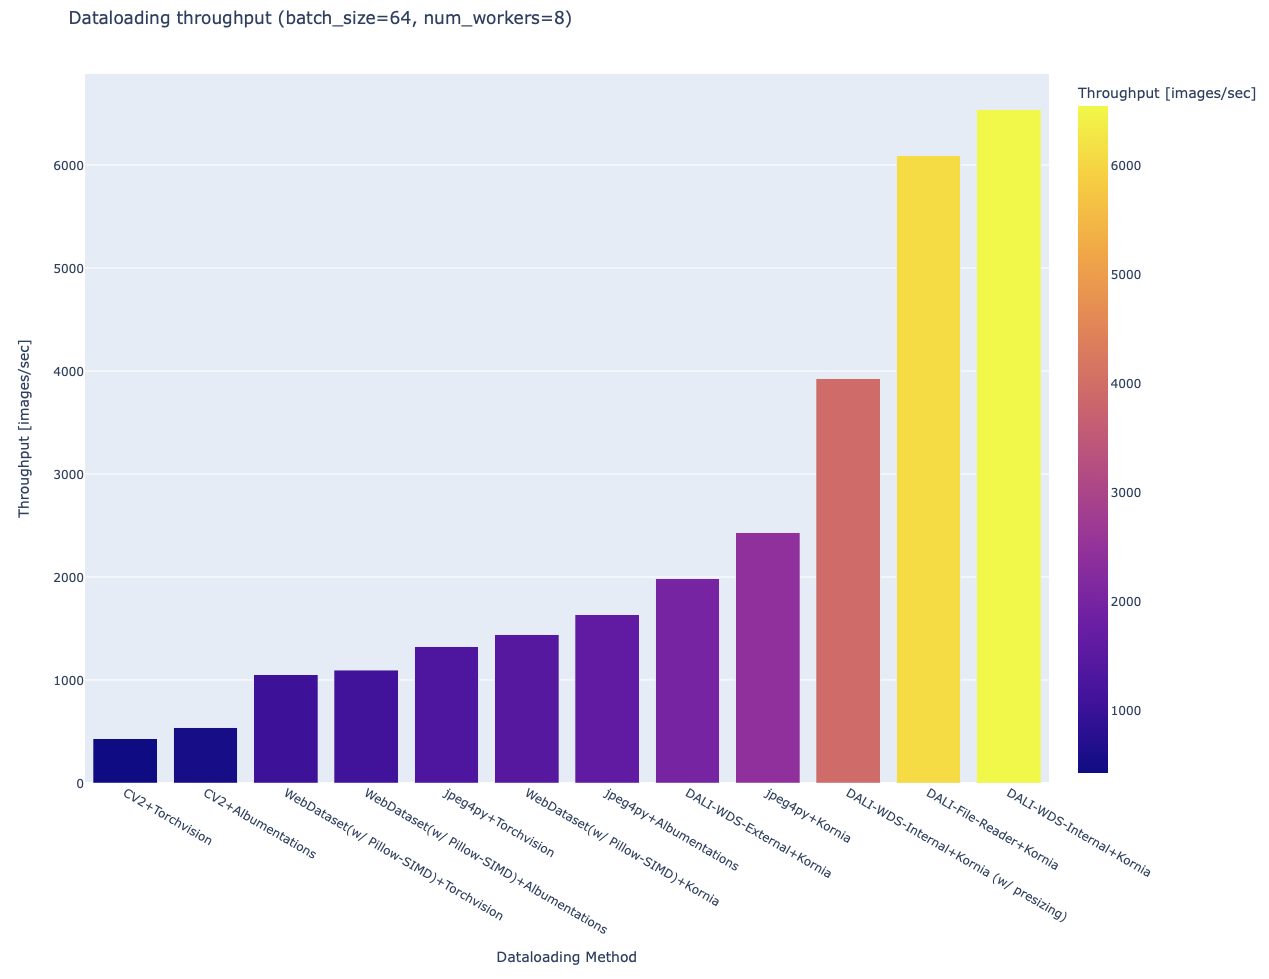

### Object detection example <a class="anchor" id="28"></a>

In this next example, we'll show how we can build a custom COCO datapipe using the original COCO format. However, in my opinion, converting COCO to webdataset is actually much cleaner. This example is adapted from [here](https://github.com/pytorch/vision/blob/7cf0f4cc1801ff1892007c7a11f7c35d8dfb7fd0/torchvision/prototype/datasets/_builtin/coco.py). If you're interested in how this can be made easier in the future, please follow [this GitHub issue](https://github.com/pytorch/vision/issues/7147).

In [ ]:
# Download the data
!mkdir -p data/vision/tiny_coco
!svn checkout https://github.com/austinmw/tiny-coco.git/trunk/tiny_coco data/vision/tiny_coco
!ls data/vision/tiny_coco

In [ ]:
import os
import csv
import requests
from typing import Any, List, Union, Sequence, Dict

from torchvision.prototype import datasets
from torchvision.prototype.datasets import register_info, register_dataset, Coco
from torchvision.prototype.datasets.utils import ManualDownloadResource

NAME = "tiny_coco"

@register_info(NAME)
def _info() -> Dict[str, Any]:
    return datasets.info('coco')

@register_dataset(NAME)
class TinyCoco(Coco):
    def _resources(self) -> List[ManualDownloadResource]:
        images_resource = ManualDownloadResource(
            file_name="train_2017_small", 
            instructions="Download from https://github.com/austinmw/tiny-coco"
        )
        meta_resource = ManualDownloadResource(
            file_name="instances_train2017.json", 
            instructions="Download from https://github.com/austinmw/tiny-coco"
        )
        resource_dp = [images_resource, meta_resource]
        return resource_dp


assert NAME in datasets.list_datasets()

dp = datasets.load("tiny_coco", root="data/vision/tiny_coco")
next(iter(dp))

## Language Data Examples <a class="anchor" id="29"></a>

### TorchText with DataLoader2 [[11]](https://github.com/pytorch/data/blob/main/examples/dataloader2/train_loop_torchtext.py) <a class="anchor" id="30"></a>

In [ ]:
import torch
from torch.hub import load_state_dict_from_url
from torchdata.dataloader2 import DataLoader2
import torchtext
import torchtext.functional as F
import torchtext.transforms as T
from torchtext.datasets import SST2
from tqdm.auto import tqdm

PADDING_IDX = 1
BOS_IDX = 0
EOS_IDX = 2
MAX_SEQ_LEN = 256
NUM_EPOCHS = 1
BATCH_SIZE = 8
XLMR_VOCAB_PATH = r"https://download.pytorch.org/models/text/xlmr.vocab.pt"
XLMR_SPM_MODEL_PATH = r"https://download.pytorch.org/models/text/xlmr.sentencepiece.bpe.model"

text_transform = T.Sequential(
    T.SentencePieceTokenizer(XLMR_SPM_MODEL_PATH),
    T.VocabTransform(load_state_dict_from_url(XLMR_VOCAB_PATH)),
    T.Truncate(MAX_SEQ_LEN - 2),
    T.AddToken(token=BOS_IDX, begin=True),
    T.AddToken(token=EOS_IDX, begin=False),
)

def apply_transform(x):
    return text_transform(x[0]), x[1]

train_datapipe = SST2(split="train")
train_datapipe = train_datapipe.map(apply_transform)
train_datapipe = train_datapipe.batch(BATCH_SIZE)
train_datapipe = train_datapipe.rows2columnar(["token_ids", "target"])
train_dataloader = DataLoader2(datapipe=train_datapipe)

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

for epoch in range(NUM_EPOCHS):
    for step, batch in tqdm(enumerate(train_dataloader), maxinterval=0.5):
        input = F.to_tensor(batch["token_ids"], padding_value=PADDING_IDX).to(DEVICE)
        target = torch.tensor(batch["target"]).to(DEVICE)

### HuggingFace Datasets <a class="anchor" id="31"></a>

In [ ]:
from torchdata.datapipes.iter import HuggingFaceHubReader

datapipe = HuggingFaceHubReader(dataset="lhoestq/demo1", split="train", revision="main", streaming=True) #, use_auth_token=True)

next(iter(datapipe))

----

## Custom DataPipes [[12]](https://pytorch.org/data/beta/tutorial.html#implementing-a-custom-datapipe) <a class="anchor" id="32"></a>

If none of the built-in DataPipes supports your need, you can create your own custom DataPipe.

As a guiding example, let us implement an IterDataPipe that applies a callable to the input iterator.

### Naming

The naming convention for `DataPipe` is “Operation”-er, followed by `IterDataPipe` or `MapDataPipe`, as each `DataPipe` is essentially a container to apply an operation to data yielded from a source `DataPipe`. For succinctness, we alias to just “Operation-er” in init files. For our `IterDataPipe` example, we’ll name the module `MapperIterDataPipe` and alias it as `iter.Mapper` under `torchdata.datapipes`.

For the functional method name, the naming convention is `datapipe.<operation>`. For instance, the functional method name of `Mapper` is `map`, such that it can be invoked by `datapipe.map(...)`.

### Constructor

DataSets are now generally constructed as stacks of DataPipes, so each `DataPipe` typically takes a source `DataPipe` as its first argument. Here is a simplified version of `Mapper` as an example:

```python
    from torchdata.datapipes.iter import IterDataPipe

    class MapperIterDataPipe(IterDataPipe):
        def __init__(self, source_dp: IterDataPipe, fn) -> None:
            super().__init__()
            self.source_dp = source_dp
            self.fn = fn
```

Note:

- Avoid loading data from the source DataPipe in `__init__` function, in order to support lazy data loading and save memory.
- If `IterDataPipe` instance holds data in memory, please be aware of the in-place modification of data. When second iterator is created from the instance, the data may have already changed. Please take `IterableWrapper` class as reference to `deepcopy` data for each iterator.
- Avoid variables names that are taken by the functional names of existing DataPipes. For instance, `.filter` is the functional name that can be used to invoke `FilterIterDataPipe`. Having a variable named `filter` inside another `IterDataPipe` can lead to confusion.

### Iterator

For `IterDataPipes`, an `__iter__` function is needed to consume data from the source `IterDataPipe` then apply the operation over the data before `yield`.

```python
    class MapperIterDataPipe(IterDataPipe):
        # ... See __init__() defined above

        def __iter__(self):
            for d in self.dp:
                yield self.fn(d)
```

### Length

In many cases, as in our `MapperIterDataPipe` example, the `__len__` method of a DataPipe returns the length of the source DataPipe.

```python
    class MapperIterDataPipe(IterDataPipe):
        # ... See __iter__() defined above

        def __len__(self):
            return len(self.dp)
```

However, note that `__len__` is optional for IterDataPipe and often inadvisable. For `CSVParserIterDataPipe` in the [Using DataPipes](#10) section, `__len__` is not implemented because the number of rows in each file is unknown before loading it. In some special cases, `__len__` can be made to either return an integer or raise an Error depending on the input. In those cases, the Error must be a `TypeError` to support Python’s build-in functions like `list(dp)`.

### Registering DataPipes with the functional API

Each DataPipe can be registered to support functional invocation using the decorator `functional_datapipe`.

```python
   from torchdata.datapipes import functional_datapipe

   @functional_datapipe("map")
   class MapperIterDataPipe(IterDataPipe):
   # ...
```

The stack of DataPipes can then be constructed using their functional forms (recommended) or class constructors:

```python
   import torchdata.datapipes as dp

   # Using functional form (recommended)
   datapipes1 = dp.iter.FileOpener(['a.file', 'b.file']).map(fn=decoder).shuffle().batch(2)
   # Using class constructors
   datapipes2 = dp.iter.FileOpener(['a.file', 'b.file'])
   datapipes2 = dp.iter.Mapper(datapipes2, fn=decoder)
   datapipes2 = dp.iter.Shuffler(datapipes2)
   datapipes2 = dp.iter.Batcher(datapipes2, 2)
```

In the above example, `datapipes1` and `datapipes2` represent the exact same stack of IterDataPipes. We recommend using the functional form of DataPipes.

----

## Distributed training <a class="anchor" id="33"></a>

A feature [currently in development](https://github.com/pytorch/data/issues/911) called `SequentialReadingService` will soon combine the features of `DistributedReadingService` and `MultiprocessingReadingService`. '

As a workaround for now, all distributed features have been added to to [`PrototypeMultiProcessingReadingService`](https://github.com/pytorch/data/blob/main/torchdata/dataloader2/reading_service.py#L150) (except attaching `fullsync` operation to the pipeline). Therefore for now dist+mp can be achieved by:

```python
    rs = PrototypeMultiProcessingReadingService(...)
    dl = DataLoader2(dp, reading_service=rs)
    dp = IterableWrapper(dl).fullsync()  # Attach FullSync to the original pipeline
```

To achieve [distributed training without MP currently](https://github.com/pytorch/data/issues/689#issuecomment-1378967719), you can do:

```python
    datapipe = source_dp.shuffle().sharding_filter()  # Make sure distributed sharding is mutually exclusive and collectively exhaustive
    datapipe = datapipe.map(transform_fn)
    ...
    def main(rank, world_size)
        dist.init_process_group(rank=rank, world_size=world_size)
        rs = DistributedReadingService()
        dl = DataLoader2(datapipe, reading_service=rs)
        for epoch in range(10):
            torch.manual_seed(epoch)  # Set determinism for all ranks
            for d in dl:
                ...
```

### With SageMaker <a class="anchor" id="34"></a>

A SageMaker example is below. The script `sagemaker/sagemaker_distributed_reading_service.py` was adapted from a TorchData example [here](https://github.com/pytorch/data/blob/main/examples/dataloader2/train_loop_distributed_reading_service.py).

In [ ]:
!mkdir -p sagemaker

In [ ]:
%%writefile sagemaker/requirements.txt
torchdata==0.5.1

In [ ]:
%%writefile sagemaker/sagemaker_distributed_reading_service.py
import os

import torch
import smdistributed.dataparallel.torch.torch_smddp
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch import nn

from torchdata.dataloader2 import DataLoader2, DistributedReadingService
from torchdata.datapipes.iter import IterableWrapper


class ToyModel(nn.Module):
    def __init__(self) -> None:
        """
        In the model constructor, we instantiate four parameters and use them
        as member parameters.
        """
        super().__init__()
        self.a = nn.Parameter(torch.randn(()))
        self.b = nn.Parameter(torch.randn(()))
        self.c = nn.Parameter(torch.randn(()))
        self.d = nn.Parameter(torch.randn(()))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Simple model forward function
        """
        return self.a + self.b * x + self.c * x ** 2 + self.d * x ** 3


if __name__ == "__main__":

    dist.init_process_group("smddp")
    world_size = dist.get_world_size()
    rank = dist.get_rank()
    local_rank = int(os.getenv("LOCAL_RANK", -1))

    #os.environ["RANK"] = str(0)
    #os.environ["WORLD_SIZE"] = str(2)
    #os.environ["MASTER_ADDR"] = "localhost"
    #os.environ["MASTER_PORT"] = "0"

    batch_size = 32
    batch_size //= world_size // 8
    batch_size = max(batch_size, 1)

    device = torch.device("cuda")

    model = ToyModel()
    model = model.to(device)
    model = DDP(model)

    # SageMaker data parallel: Pin each GPU to a single library process.
    torch.cuda.set_device(local_rank)
    model.cuda(local_rank)

    # Use a prime number to make sure uneven data sharding and let
    # DistributedReadingService prevent hanging with the unbalanced data shard
    data_length = 19997

    train_features = IterableWrapper([torch.rand(3) for _ in range(data_length)])
    train_labels = IterableWrapper([torch.rand(3) for _ in range(data_length)])

    # sharding_filter will automatically shard the data based on the
    # distributed ranks
    train_data_pipe = train_features.zip(train_labels).shuffle().sharding_filter()

    # Torch Distributed is required to use DistributedReadingService
    reading_service = DistributedReadingService()
    # To track SequentialReadingService: https://github.com/pytorch/data/issues/911
    #reading_service = PrototypeMultiProcessingReadingService(num_workers=8)

    # Create DataLoader2 with DistributedReadingService
    data_loader2 = DataLoader2(
        datapipe=train_data_pipe,
        reading_service=reading_service,
    )

    criterion = torch.nn.MSELoss(reduction="sum")
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)

    for epoch in range(10):

        # Set manual seed per epoch to control the randomness for shuffle.
        torch.manual_seed(epoch)

        running_loss = 0.0
        for step, data in enumerate(data_loader2):
            train_feature, train_label = data
            train_feature = train_feature.to(device)
            train_label = train_label.to(device)
            optimizer.zero_grad()

            predicted_outputs = model(train_feature)
            loss = criterion(predicted_outputs, train_label)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if rank == 0 and step % 50 == 0:
                print("[epoch: %d, %5d] loss: %.3f" % (epoch + 1, step + 1, running_loss / 2000))
            running_loss = 0.0

        # SageMaker data parallel: Save model on master node.
        if rank == 0:
            torch.save(model.state_dict(), "/opt/ml/model/model.pth")

    if rank == 0:
        print("Finished Training")

In [ ]:
%%time
import sagemaker
from sagemaker.pytorch import PyTorch

session = sagemaker.Session()
role = sagemaker.get_execution_role(sagemaker_session=session)

estimator = PyTorch(
    role=role,
    source_dir="sagemaker",
    entry_point="sagemaker_distributed_reading_service.py",
    image_uri="763104351884.dkr.ecr.us-west-2.amazonaws.com/pytorch-training:1.13.1-gpu-py39-cu117-ubuntu20.04-sagemaker",
    instance_count=2,
    # Instance types supported by the SageMaker data parallel library: 
    # ml.p4d.24xlarge, ml.p3dn.24xlarge, and ml.p3.16xlarge
    instance_type="ml.p3.16xlarge",
    # Training using the SageMaker data parallel distributed training strategy
    distribution={ "smdistributed": { "dataparallel": { "enabled": True } } }
)

estimator.fit()

## S3FileLoader <a class="anchor" id="35"></a>

TorchData now provides a new [`S3FileLoader`](https://pytorch.org/data/main/generated/torchdata.datapipes.iter.S3FileLoader.html) Iterable DataPipe that loads Amazon S3 files from the given S3 URLs.

Note that the below example of `S3FileLoader` isn't necessary if using Amazon SageMaker's Fast File Mode. Fast File Mode exposes S3 objects using a POSIX-compliant file system interface. This means that data can be used as if it were available on your local system. It streams this data on demand, and performs better when files are read sequentially.

In [ ]:
from sagemaker import Session

session = Session()
bucket = session.default_bucket()

In [ ]:
# Upload data to S3
!aws s3 sync data/vision/webdataset s3://$bucket/data/vision/webdataset

In [ ]:
from functools import partial

import torch
import torchvision.transforms as transforms
from torchdata.datapipes.iter import IterableWrapper, S3FileLoader
from webdataset.autodecode import imagehandler


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define image decoders
pil_handler = imagehandler('pil')

# Define simple transforms (since resizing is required to collate)
data_transform = transforms.Compose([transforms.RandomResizedCrop(256),])

# Define how to decode webdataset keys
def decode(item, transform=data_transform, image_decoder=pil_handler):
    key, value = item
    if key.endswith(".cls"):
        class_id = int(value.read().decode("utf-8"))
        return key, class_id
    elif key.endswith(".jpg"):
        image = image_decoder(".jpg", value.read())
        return key, transform(image)

# Define simple collate function
def collate_fn(batch, device=device):
    classes = torch.Tensor([sample['.cls'] for sample in batch]).to(device)
    images = torch.stack([sample['.jpg'] for sample in batch]).to(device)
    return classes, images

# Create pipeline
dp_s3_urls = IterableWrapper([f's3://{bucket}/data/vision/webdataset',]).list_files_by_s3()
dp = (dp_s3_urls.filter(lambda x: x.endswith(".tar"))
      .shuffle()
      .sharding_filter()
      .load_files_by_s3()
      .load_from_tar()
      .map(decode)
      .webdataset()
      #.batch(8)
      #.collate()
)

next(iter(dp))['.jpg']

----

## AIStore on S3 [[13]](https://github.com/NVIDIA/aistore/blob/master/python/aistore/examples/aisio-pytorch/aisio_pytorch_example.ipynb) <a class="anchor" id="36"></a>

[AIStore](https://github.com/NVIDIA/aistore#features) is a lightweight object storage system with the capability to linearly scale out with each added storage node and a special focus on petascale deep learning.

Paper: [High Performance I/O for Large Scale Deep Learning](https://arxiv.org/abs/2001.01858)

Blog [2020]: [Efficient PyTorch I/O library for Large Datasets, Many Files, Many GPUs](https://pytorch.org/blog/efficient-pytorch-io-library-for-large-datasets-many-files-many-gpus)

### Running the AIStore Cluster

[AIStore](https://github.com/NVIDIA/aistore) (AIS for short) is a highly available lightweight object storage system that specifically focuses on petascale deep learning. As a reliable redundant storage, AIS supports n-way mirroring and erasure coding. But it is not purely – or not only – a storage system: it’ll shuffle user datasets and run custom extract-transform-load workloads.

AIS is an elastic cluster that can grow and shrink at runtime and can be ad-hoc deployed, with or without Kubernetes, anywhere from a single Linux machine to a bare-metal cluster of any size. AIS fully supports Amazon S3, Google Cloud, and Microsoft Azure backends, providing a unified namespace across multiple connected backends and/or other AIS clusters, and [more](https://github.com/NVIDIA/aistore#features).

[Getting started with AIS](https://github.com/NVIDIA/aistore/blob/master/docs/getting_started.md) will take only a few minutes (prerequisites boil down to having a Linux with a disk) and can be done either by running a prebuilt [all-in-one docker image or directly from the open-source](https://github.com/NVIDIA/aistore/tree/master/deploy).

To keep this example simple, we will be running a [minimal standalone docker deployment of AIStore](https://github.com/NVIDIA/aistore/blob/master/deploy/prod/docker/single/README.md).

In [ ]:
# Running the AIStore cluster in a container on port 51080
# Note: The mounted path should have enough space to load the dataset

! docker run -d \
    -p 51080:51080 \
    -e AWS_ACCESS_KEY_ID="FILL IN" \
    -e AWS_SECRET_ACCESS_KEY="FILL IN" \
    -e AWS_DEFAULT_REGION="us-west-2" \
    -e AIS_BACKEND_PROVIDERS="aws" \
    --name aistore \
    -v /disk0:/ais/disk0 \
    aistore/cluster-minimal:latest

To create and put objects (dataset) in the bucket, we can use the [AIS CLI](https://github.com/NVIDIA/aistore/blob/master/docs/cli.md), the [Python SDK](https://github.com/NVIDIA/aistore/tree/master/python/aistore), or a combination of both.

In order to interact with your running AIS instance, you will need to create a client object:

In [ ]:
from aistore import Client

client = Client("http://localhost:51080")

In [ ]:
# Check if AIS is deployed and running
client.cluster().is_aistore_running()

In [ ]:
# Get cluster information
client.cluster().get_info()

In [ ]:
# Create a bucket named "cifar10"
bucket = "cifar10"
client.bucket(bucket).create()

In [ ]:
# Download the dataset to the local machine
from torchdata.datapipes.iter import IterDataPipe
from torchvision.prototype import datasets

root = "data/vision/cifar10"
split = "train"
train = datasets.load("cifar10", root=root, split=split)

In [ ]:
# Put in aistore
! ais config cli set cluster.url=http://localhost:51080
! ais object put -r -y data/vision/cifar10 ais://cifar10/

In [ ]:
client.bucket(bucket).list_objects()

### PyTorch Integration

You can list and load data from AIS buckets (buckets that are not 3rd party backend-based) and remote cloud buckets (3rd party backend-based cloud buckets) in PyTorch using `AISFileLister` and `AISFileLoader`.

`AISFileLister` and `AISFileLoader` are now available as a part of official pytorch/data project.


```python
    from torchdata.datapipes.iter import AISFileLister, AISFileLoader

    # provide list of prefixes to load and list data from
    ais_prefixes = ['gcp://bucket-name/folder/', 'aws:bucket-name/folder/', 'ais://bucket-name/folder/', ...]

    # List all files for these prefixes using AISFileLister
    dp_ais_urls = AISFileLister(url='localhost:8080', source_datapipe=ais_prefixes)

    # print(list(dp_ais_urls))

    # Load files using AISFileLoader
    dp_files = AISFileLoader(url='localhost:8080', source_datapipe=dp_ais_urls)

    for url, file in dp_files:
        pass
```

### Preloaded dataset

The following assumes that AIS cluster is running and one of its buckets contains Caltech-256 dataset.

In [ ]:
import aistore
aistore.__version__

In [ ]:
from torchdata.datapipes.iter import AISFileLister, AISFileLoader

# list of prefixes which contain data
image_prefix = ["ais://cifar10/"]

# Listing all files starting with these prefixes on AIStore
dp_urls = AISFileLister(url="http://localhost:51080", source_datapipe=image_prefix)

# list obj urls
print(list(dp_urls))

# loading data using AISFileLoader
dp = AISFileLoader(url="http://localhost:51080", source_datapipe=dp_urls)

Since cifar10 is small, we only see one file above. 

Next we'll build a DataPipe to load torchvision's cifar10 `tar.gz` data. Check this out in more detail [here](https://github.com/pytorch/vision/blob/main/torchvision/prototype/datasets/_builtin/cifar.py).

In [ ]:
import io
import pathlib
import pickle
from typing import Any, BinaryIO, cast, Dict, Iterator, List, Optional, Tuple, Union

import numpy as np
import torch
from torchdata.datapipes.iter import TarArchiveLoader, Filter, IterDataPipe, Mapper
from torchvision.prototype.datapoints import Image, Label
from torchvision.prototype.datasets.utils._internal import (
    hint_sharding,
    hint_shuffling,
    path_comparator,
    read_categories_file,
)

class CifarFileReader(IterDataPipe[Tuple[np.ndarray, int]]):
    def __init__(self, datapipe: IterDataPipe[Dict[str, Any]], *, labels_key: str) -> None:
        self.datapipe = datapipe
        self.labels_key = labels_key

    def __iter__(self) -> Iterator[Tuple[np.ndarray, int]]:
        for mapping in self.datapipe:
            image_arrays = mapping["data"].reshape((-1, 3, 32, 32))
            category_idcs = mapping[self.labels_key]
            yield from iter(zip(image_arrays, category_idcs))

categories = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

split = "train"

def _is_data_file(data: Tuple[str, Any]) -> bool:
    path = pathlib.Path(data[0])
    return path.name.startswith("data" if split == "train" else "test")

def _unpickle(data: Tuple[str, io.BytesIO]) -> Dict[str, Any]:
    _, file = data
    content = cast(Dict[str, Any], pickle.load(file, encoding="latin1"))
    file.close()
    return content

def _prepare_sample(data: Tuple[np.ndarray, int]) -> Dict[str, Any]:
    image_array, category_idx = data
    return dict(
        image=Image(image_array),
        label=Label(category_idx, categories=categories),
    )

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dp = TarArchiveLoader(dp)
dp = Filter(dp, _is_data_file)
dp = Mapper(dp, _unpickle)
dp = CifarFileReader(dp, labels_key="labels")
dp = hint_shuffling(dp)
dp = hint_sharding(dp)
dp = Mapper(dp, _prepare_sample)
dp = dp.batch(8).collate()

for x in dp:
    print(x.keys())
    images = x['image'].to(device)
    labels = x['label'].to(device)
    print(images.shape)
    break

In [ ]:
import torchvision.transforms as T

T.ToPILImage()(images[0])

In [16]:
client.bucket(bucket).delete()

### Boto3 Compatibility

To use boto3 or botocore as client libraries for AIStore:

In [ ]:
import boto3
from aistore.botocore_patch import botocore

----

## References <a class="anchor" id="37"></a>

- [1] https://github.com/pytorch/data/blob/main/README.md#torchdata
- [2] https://github.com/pytorch/data/blob/main/README.md#why-composable-data-loading
- [3] https://github.com/pytorch/data/blob/main/README.md#what-are-datapipes
- [4] https://pytorch.org/data/main/tutorial.html
- [5] https://sebastianraschka.com/blog/2022/datapipes.html
- [6] https://github.com/pytorch/data#frequently-asked-questions-faq
- [7] https://pytorch.org/data/beta/dataloader2.html#module-torchdata.dataloader2
- [8] https://github.com/pytorch/vision/tree/main/torchvision/prototype/datasets/_builtin#how-do-i-compute-the-number-of-samples
- [9] https://github.com/pytorch/torcharrow#torcharrow-a-data-processing-library-for-pytorch
- [10] https://github.com/pytorch/data/blob/main/examples/vision/imagefolder.py
- [11] https://github.com/pytorch/data/blob/main/examples/dataloader2/train_loop_torchtext.py
- [12] https://pytorch.org/data/beta/tutorial.html#implementing-a-custom-datapipe
- [13] https://github.com/NVIDIA/aistore/blob/master/python/aistore/examples/aisio-pytorch/aisio_pytorch_example.ipynb